In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from IPython import display
import time
import glob

from math import *
import random

def tovar(x):
    return torch.FloatTensor(x).cuda()

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet,self).__init__()
        
        self.l1a = nn.Conv2d(3,32,5,padding=2)
        nn.init.orthogonal_(self.l1a.weight, gain=sqrt(2))
        self.b1a = nn.BatchNorm2d(32)
        self.l1b = nn.Conv2d(32,32,5,padding=2)
        self.b1b = nn.BatchNorm2d(32)
        nn.init.orthogonal_(self.l1b.weight, gain=sqrt(2))
        self.p1 = nn.MaxPool2d(2)
        
        self.l2a = nn.Conv2d(32,64,5,padding=2)
        self.b2a = nn.BatchNorm2d(64)
        nn.init.orthogonal_(self.l2a.weight, gain=sqrt(2))
        self.l2b = nn.Conv2d(64,64,5,padding=2)
        self.b2b = nn.BatchNorm2d(64)
        nn.init.orthogonal_(self.l2b.weight, gain=sqrt(2))
        self.p2 = nn.MaxPool2d(2)

        self.l3a = nn.Conv2d(64,128,5,padding=2)
        self.b3a = nn.BatchNorm2d(128)
        nn.init.orthogonal_(self.l3a.weight, gain=sqrt(2))
        self.l3b = nn.Conv2d(128,128,5,padding=2)
        self.b3b = nn.BatchNorm2d(128)
        nn.init.orthogonal_(self.l3b.weight, gain=sqrt(2))
        self.p3 = nn.MaxPool2d(2)
        
        self.l4a = nn.Conv2d(128,256,5,padding=2)
        self.b4a = nn.BatchNorm2d(256)
        nn.init.orthogonal_(self.l4a.weight, gain=sqrt(2))
        self.l4b = nn.Conv2d(256,256,5,padding=2)
        self.b4b = nn.BatchNorm2d(256)
        nn.init.orthogonal_(self.l4b.weight, gain=sqrt(2))
        self.p4 = nn.MaxPool2d(2)
        
        self.l5 = nn.Linear(256,16,1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        z = x
        z = F.leaky_relu(self.l1a(z))
        z = self.b1a(z)
        z = F.leaky_relu(self.l1b(z))
        z = self.b1b(z)
        z = self.p1(z)
        
        z = F.leaky_relu(self.l2a(z))
        z = self.b2a(z)
        z = F.leaky_relu(self.l2b(z))
        z = self.b2b(z)
        z = self.p2(z)
        
        z = F.leaky_relu(self.l3a(z))
        z = self.b3a(z)
        z = F.leaky_relu(self.l3b(z))
        z = self.b3b(z)
        z = self.p3(z)
        
        z = F.leaky_relu(self.l4a(z))
        z = self.b4a(z)
        z = F.leaky_relu(self.l4b(z))
        z = self.b4b(z)
        z = self.p4(z).mean(3).mean(2)
        
        z = self.l5(z)
        z = z/torch.sqrt(torch.sum(z**2,1)+1e-4).unsqueeze(1)
        
        return z

In [4]:
def imload(fname):
    im = Image.open(fname)
    im = (np.array(im)-128.0)/128.0
    x0 = np.random.randint(im.shape[0]-128)
    y0 = np.random.randint(im.shape[1]-128)    
    return im[x0:x0+128,y0:y0+128,:]

def getBatch(N=20):
    x1 = []
    x2 = []
    x3 = []
    
    for i in range(N):
        c1 = np.random.randint(2000)
        c2 = np.random.randint(2000)
        
        k1 = np.random.randint(50)
        k2 = np.random.randint(50)
        k3 = np.random.randint(50)
        
        x1.append(imload("data/%.6d/%.6d.png" % (c1,k1)))
        x2.append(imload("data/%.6d/%.6d.png" % (c1,k2)))
        x3.append(imload("data/%.6d/%.6d.png" % (c2,k3)))
    
    x1 = np.array(x1).transpose(0,3,1,2)
    x2 = np.array(x2).transpose(0,3,1,2)
    x3 = np.array(x3).transpose(0,3,1,2)
    
    return x1,x2,x3


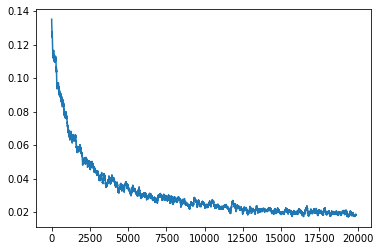

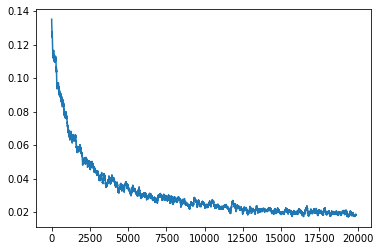

In [5]:
net = Triplet().cuda()
net.load_state_dict(torch.load("triplet_ca.pth"))

tr_err = []
lossfn = nn.TripletMarginLoss(margin=1)

for p in net.optim.param_groups:
    p['lr'] = 1e-5

for epoch in range(20000):
    net.optim.zero_grad()
    
    net.train()
    err = []
    for i in range(10):
        x1,x2,x3 = getBatch(N=10)
        x1 = tovar(x1)
        x2 = tovar(x2)
        x3 = tovar(x3)

        y1 = net.forward(x1)
        y2 = net.forward(x2)
        y3 = net.forward(x3)

        loss = lossfn(y1,y2,y3)# + 1e-2 * ( torch.mean(y1**2) + torch.mean(y2**2) + torch.mean(y3**2))
        loss.backward()
        err.append(loss.cpu().detach().item())
    net.optim.step()
    
    tr_err.append(np.mean(err))
    plt.clf()
    cs = np.cumsum(tr_err)
    cs = (cs[100:] - cs[:-100])/100.0
    plt.plot(cs)
    #plt.plot(tr_err)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [6]:
torch.save(net.state_dict(), open("triplet_CellLib.pth","wb"))

In [7]:
net.eval()

ims = []
latents = []

for i in range(200):
    x1,x2,x3 = getBatch()
    
    z1 = net.forward(tovar(x1)).cpu().detach().numpy()
    z2 = net.forward(tovar(x2)).cpu().detach().numpy()
    z3 = net.forward(tovar(x3)).cpu().detach().numpy()
    
    for i in range(x1.shape[0]):
        ims.append(np.clip(0.5+0.5*x1[i].transpose(1,2,0),0,1))
        #ims.append(np.clip(0.5+0.5*x2[i].transpose(1,2,0),0,1))
        ims.append(np.clip(0.5+0.5*x3[i].transpose(1,2,0),0,1))
        latents.append(z1[i])
        #latents.append(z2[i])
        latents.append(z3[i])
ims = np.array(ims)
latents = np.array(latents)

In [10]:
import umap

clf = umap.UMAP(n_components=2, min_dist = 0.5)

ulatents = clf.fit_transform(latents)

/home/esilverman/anaconda3/envs/pytorch3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/pytorch3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [11]:
ulatents.shape[0]

8000

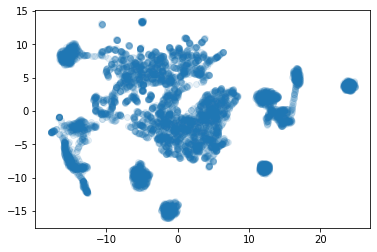

In [12]:
plt.scatter(ulatents[:,0], ulatents[:,1], alpha=0.1)
plt.show()

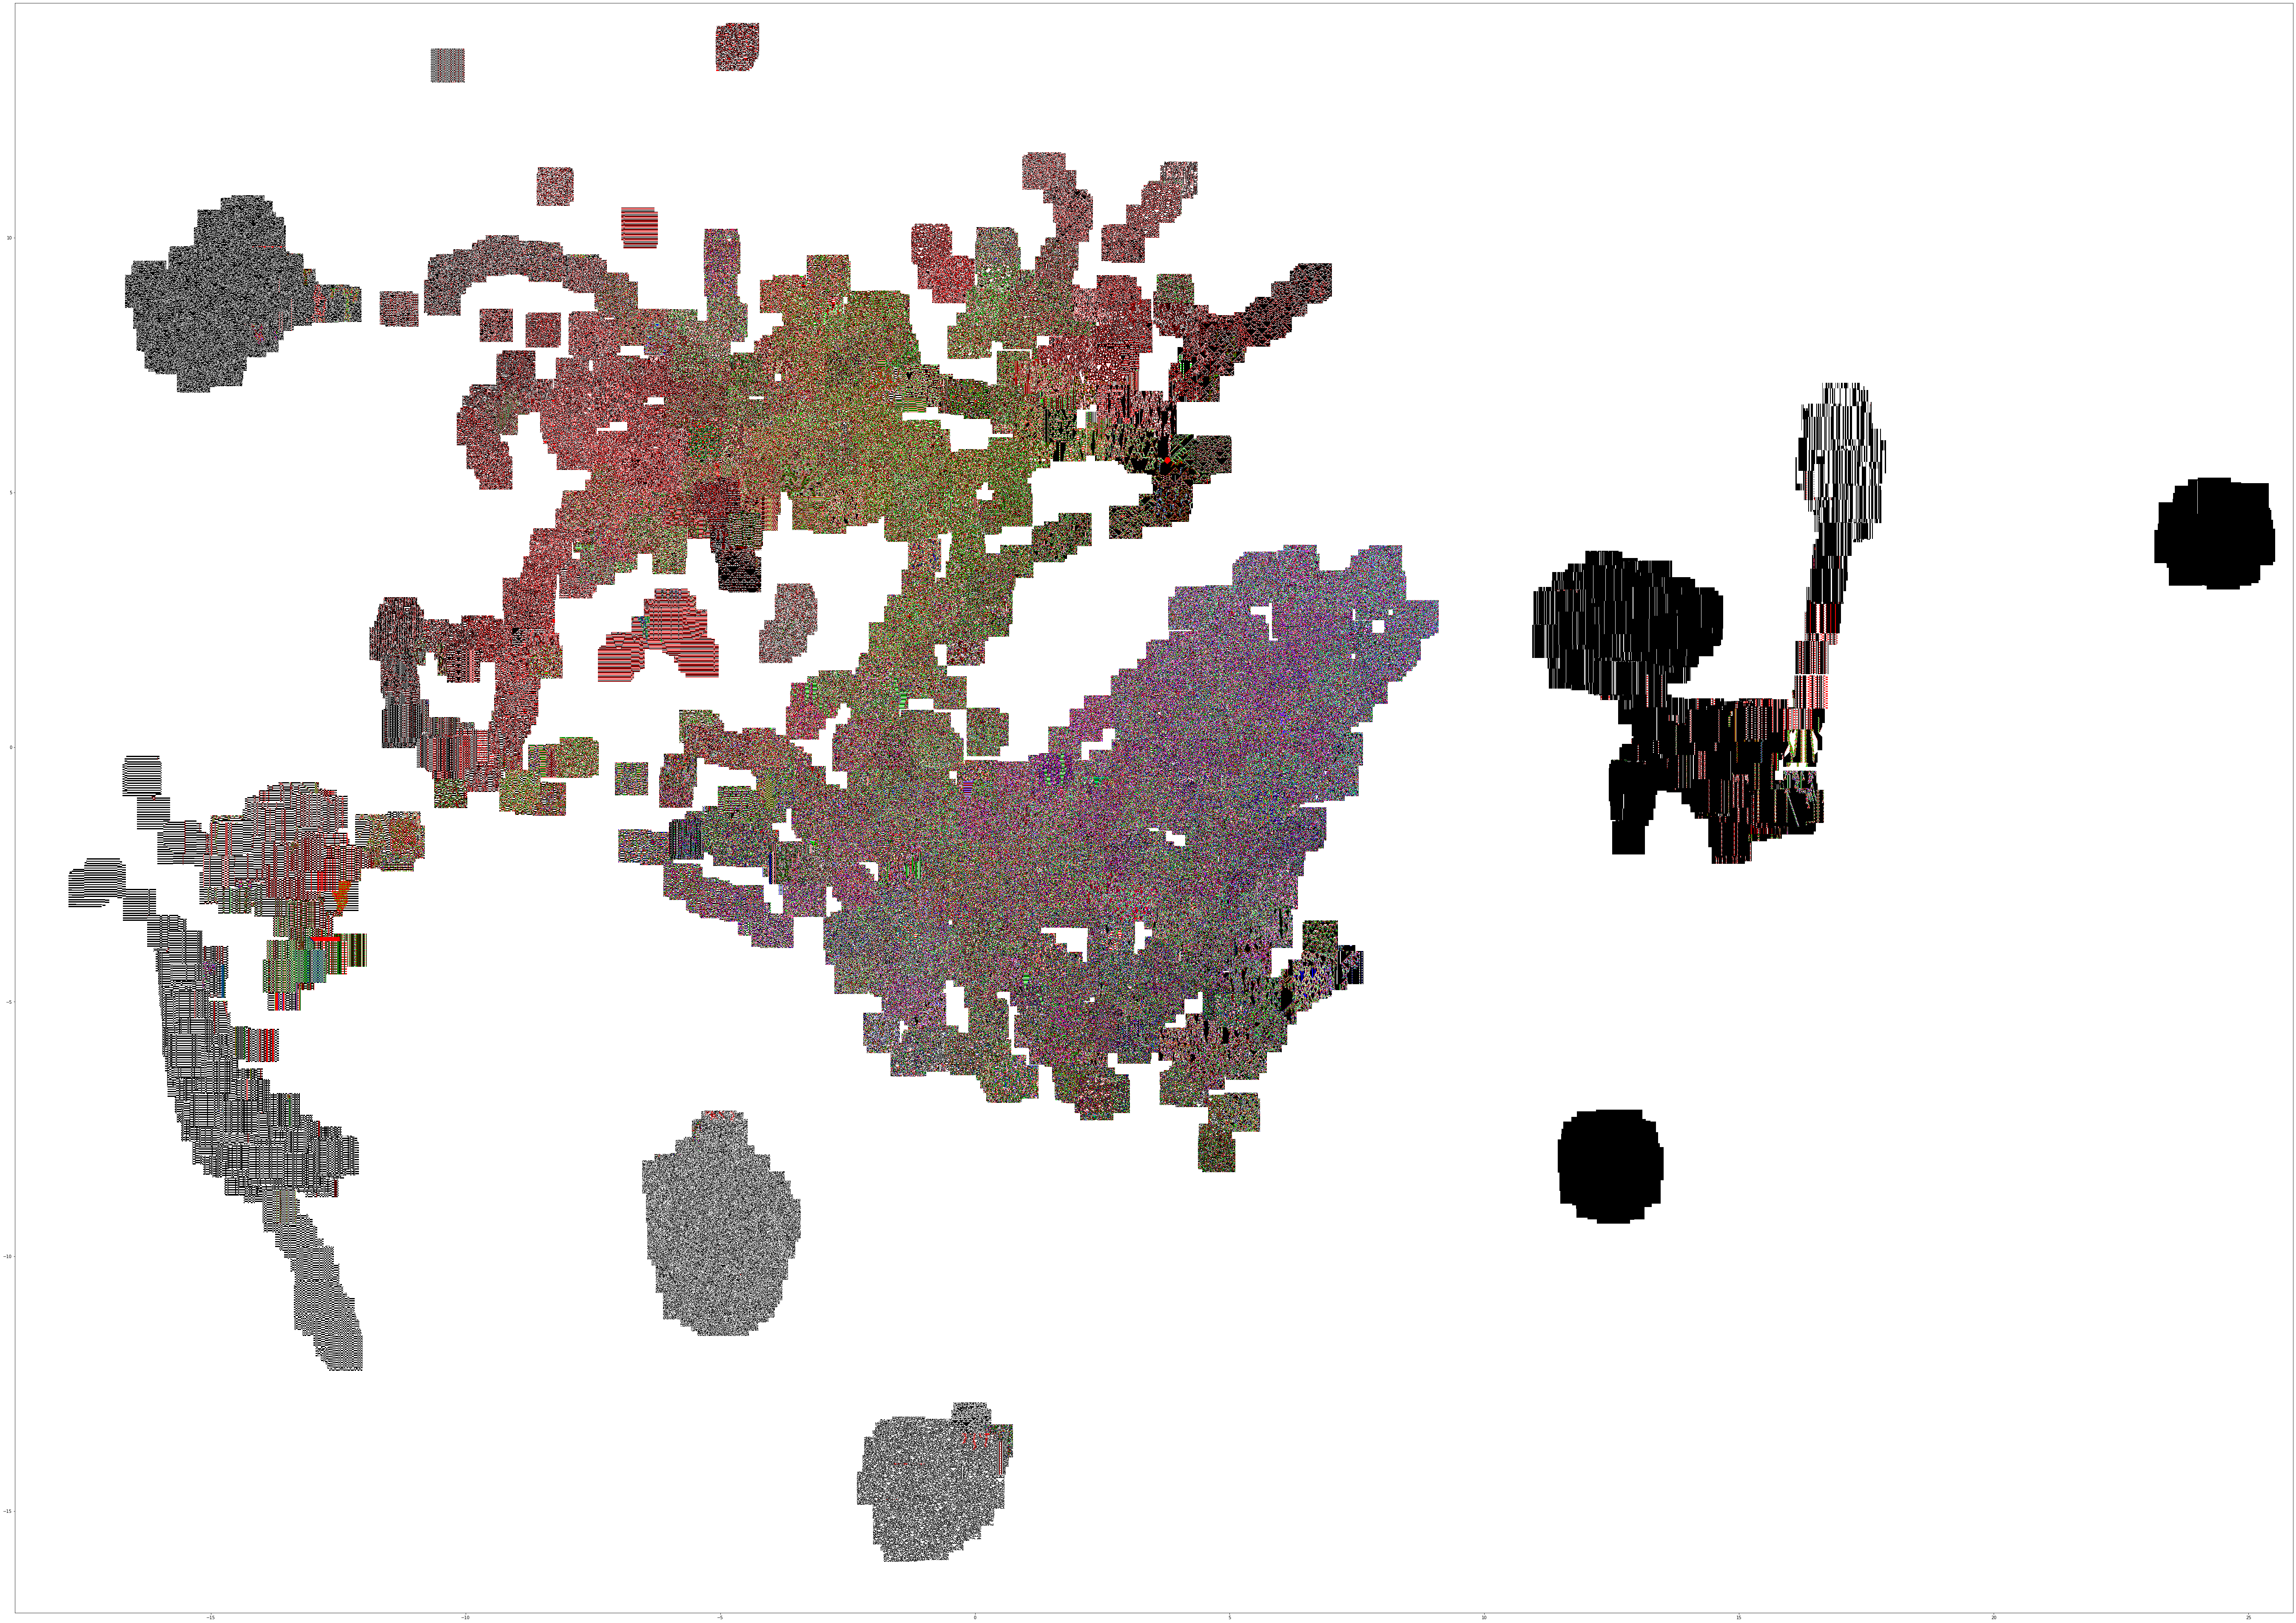

In [13]:
for i in range(0,ims.shape[0],2):
    plt.imshow(ims[i], extent=[ulatents[i,0], ulatents[i,0]+0.5*1.3, ulatents[i,1], ulatents[i,1]+0.5*1.3])

xmin = np.min(ulatents[:,0])
xmax = np.max(ulatents[:,0])
ymin = np.min(ulatents[:,1])
ymax = np.max(ulatents[:,1])
plt.xlim(xmin-1,xmax+1)
plt.ylim(ymin-1,ymax+1)

plt.gcf().set_size_inches((96,96))
plt.show()

In [14]:
def canonicalize(im):
    iim = (256*im[:,:,0]).astype(np.int32) + 256*(256*im[:,:,1]).astype(np.int32) + 256*256*(256*im[:,:,2]).astype(np.int32)
    colors = np.unique(iim)
    counts = np.array([ np.sum(iim == colors[i]) for i in range(colors.shape[0])])
    reidx = np.argsort(-counts)
    colors = colors[reidx]
    
    idx = np.zeros((iim.shape[0], iim.shape[1]))
    for i in range(colors.shape[0]):
        match = 1.0*(iim==colors[i])
        idx = idx*(1-match) + i*match
    idx = idx.astype(np.int32)
    
    rgbset = np.array([
        [0.4, 0.4, 0.4],
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.8, 0.0, 0.8]])
    
    newim = rgbset[idx]
    
    return newim

In [15]:
xmin = np.min(ulatents[:,0])-1
xmax = np.max(ulatents[:,0])+1
ymin = np.min(ulatents[:,1])-1
ymax = np.max(ulatents[:,1])+1

XR = 64
YR = 64
im = np.zeros((128*XR,128*YR,3))+0.5

for x in range(XR):
    for y in range(YR):
        posx = xmin+(xmax-xmin)*(x+0.5)/XR
        posy = ymin+(ymax-ymin)*(y+0.5)/YR
        
        dist = (ulatents[:,0] - posx)**2 + (ulatents[:,1]-posy)**2
        nearest = np.argmin( dist )
        mindist = dist[nearest]
        
        if mindist<0.125:
            im[128*x:128*x+128,128*y:128*y+128,:] = ims[nearest]

im = np.clip(256*im,0,255).astype(np.uint8)
im = Image.fromarray(im)
im.save("ca_embedding.png")

In [16]:
np.min(latents)

-0.7250146